<a href="https://colab.research.google.com/github/samlarson94/CDN-Seedling-Computer-Vision/blob/main/CDN_Model_Plant_Seedling_Classification_Larson2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Label.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

####**Note: Please use GPU runtime to execute the code efficiently**

## Importing necessary libraries

In [ ]:
#Reading the training images from the path and labelling them into the given categories
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 # this is an important module to get imported which may even cause issues while reading the data if not used
import seaborn as sns # for data visualization
import tensorflow as tf
import keras
import os
from tensorflow.keras.models import Sequential #sequential api for sequential model
from tensorflow.keras.layers import Dense, Dropout, Flatten #importing different layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU,Activation
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical #to perform one-hot encoding
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam,SGD #optimiers for optimizing the model
from tensorflow.keras.callbacks import EarlyStopping  #regularization method to prevent the overfitting
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import losses, optimizers
# Importing all the required sub-modules from Keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

from sklearn.model_selection import train_test_split
import random
from sklearn import metrics

## Loading the dataset

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load Images File
file_path = '/content/drive/MyDrive/DataScience/Project_8_CDNPlantSeedlingRecognition/images.npy'
images = np.load(file_path)

In [ ]:
# Load Labels
file_path = '/content/drive/MyDrive/DataScience/Project_8_CDNPlantSeedlingRecognition/Labels.csv'
labels = pd.read_csv(file_path)

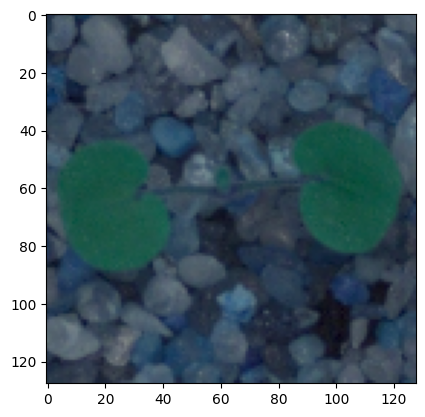

In [ ]:
# Verify with sample_image
sample_image = images[0]
plt.imshow(sample_image)
plt.show()

In [ ]:
# Verify labels
print(labels)

                          Label
0     Small-flowered Cranesbill
1     Small-flowered Cranesbill
2     Small-flowered Cranesbill
3     Small-flowered Cranesbill
4     Small-flowered Cranesbill
...                         ...
4745           Loose Silky-bent
4746           Loose Silky-bent
4747           Loose Silky-bent
4748           Loose Silky-bent
4749           Loose Silky-bent

[4750 rows x 1 columns]


## Data Overview

### Understand the shape of the dataset

In [ ]:
# Check Shape
print("Shape of the loaded image data:", images.shape)
print("Shape of the loaded labels:", labels.shape)

Shape of the loaded image data: (4750, 128, 128, 3)
Shape of the loaded labels: (4750, 1)


We have 4750 images, each with dimensions of 128x128 px and 3 color channels (RGB).
We also have 4750 labels to work with.

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

In [ ]:
def plot_images(images,labels):
  classes=10 # number of classes
  categories=np.unique(labels)
  keys=dict(labels['Label']) # grab different classes
  # Define number of rows and columns
  rows = 3
  cols = 4
  fig = plt.figure(figsize=(10, 8)) # set fig size
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels)) # generate random indices
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)
          ax.imshow(images[random_index, :])
          ax.set_title(keys[random_index])
  plt.show()

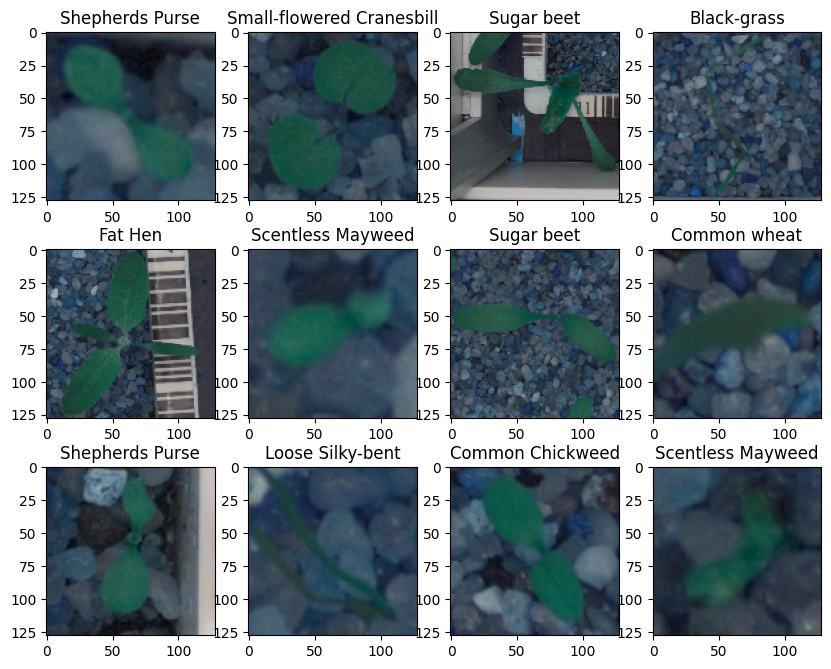

In [ ]:
# Call function to generate randomized, labeled example images from dataset
plot_images(images, labels)

These seedling images vary primarily in shape, though some are very similar to others.

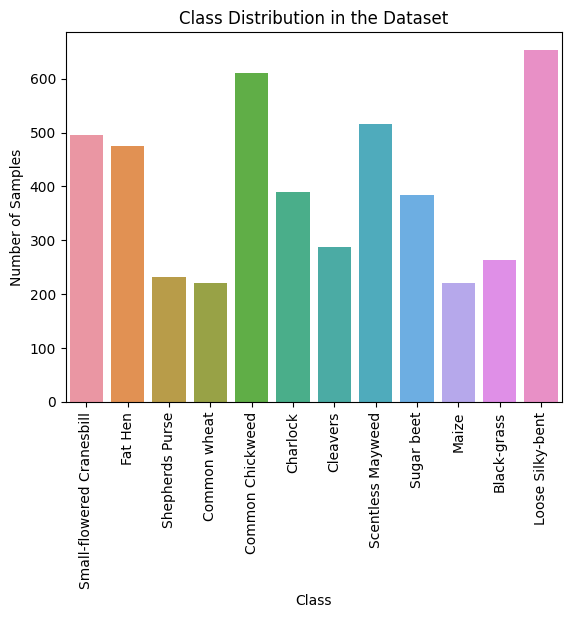

In [ ]:
# Checking Distribution via Plot
label_vals = labels['Label'].tolist()
sns.countplot(x=label_vals)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in the Dataset')
plt.xticks(rotation='vertical')  # Rotate x-axis labels for better readability
plt.show()

As shown above, our dataset is imbalanced. With varying sample counts for the different labels.

We may want to consider methods such as oversampling, undersampling, or using class weights here.

## Data Pre-Processing

### Convert the BGR images to RGB images.

In [ ]:
# Convert Images to RGB
for i in range(len(images)):
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [ ]:
# Define new Dimensions
width = 64
height = 64
dimensions = (width, height)

# Create List to Store new Images
images_decreased = []

# Loop through and change image sizing
for i in range(len(images)):
    resized_image = cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR)
    images_decreased.append(resized_image)

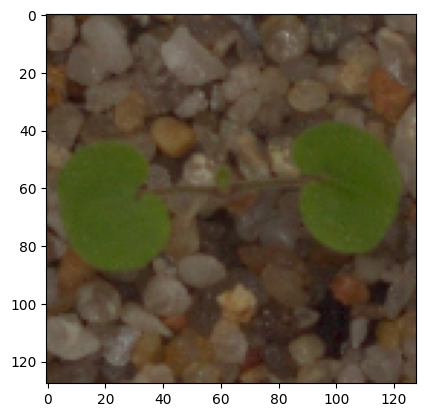

In [ ]:
# Verify Resizing by Visual Comparison
plt.imshow(images[0]) #Image ex. before resizing

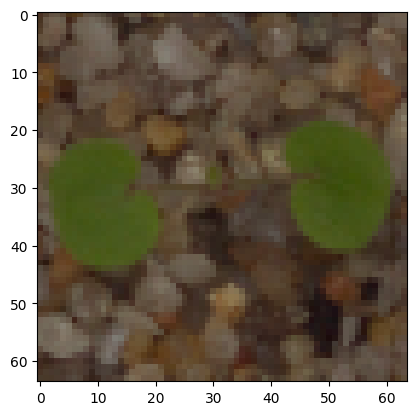

In [ ]:
plt.imshow(images_decreased[0]) #Image ex. after resizing

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [ ]:
# Split data with test_size as 0.1
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased), labels, test_size=0.1, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42, stratify=y_temp)

In [ ]:
# Verify by checking shapes
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


### Encode the target labels

In [ ]:
# Encoding Target Variables (labels)
from sklearn.preprocessing import LabelBinarizer

# Using LabelBinarizer as our encoder
encoder = LabelBinarizer()

# Fit and transform y_train
y_train_encoded = encoder.fit_transform(y_train)

# Transform y_val and y_test
y_val_encoded = encoder.transform(y_val)
y_test_encoded = encoder.transform(y_test)

In [ ]:
# Checking Shapes for Verification
y_train_encoded.shape, y_val_encoded.shape, y_test_encoded.shape

((3847, 12), (428, 12), (475, 12))

### Data Normalization

In [ ]:
# Since our Data's pixel values range from 0-255, we will standardize them by dividing them by 255.0.
  # This will normalize them between the values of 0 and 1.
X_train_normalized = X_train.astype('float32') / 255.0
X_val_normalized = X_val.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0

## Model Building

In [ ]:
# Prep - clear backend session
backend.clear_session()

In [ ]:
# Prep - Fix seed for random num generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Initialize a sequential model
model1 = Sequential()

# First convolutional layer with (128) filters and a kernel size of 3x3
  # Padding 'same' provides the output size same as the input size
model1.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3))) #Input shape 64x64 pixels

# Adding max pooling to reduce the size of the output of the first conv layer
model1.add(MaxPooling2D((2, 2), padding='same'))

# Adding two similar convolution and max-pooling layers with relu activation
model1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding='same'))

model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding='same'))

# Flattening our output of the convolutional layer after max pooling
model1.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.3))

# This is a multi-class problem, so adding the output layer with 12 neurons and activation function as softmax
model1.add(Dense(12, activation='softmax'))

# Adam optimizer
optimizer = Adam()

# Compiling the model using suitable metric for the loss function
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 32)          0

In [ ]:
# Fit Model1 to Training Data
history_1 = model1.fit(
    X_train_normalized, y_train_encoded,
    epochs=30,
    validation_data=(X_val_normalized, y_val_encoded),
    batch_size=32,
    verbose=2
)

Epoch 1/30
121/121 - 13s - loss: 2.4503 - accuracy: 0.1180 - val_loss: 2.4191 - val_accuracy: 0.1542 - 13s/epoch - 107ms/step
Epoch 2/30
121/121 - 1s - loss: 2.2866 - accuracy: 0.2407 - val_loss: 2.0201 - val_accuracy: 0.3692 - 1s/epoch - 9ms/step
Epoch 3/30
121/121 - 1s - loss: 2.0518 - accuracy: 0.3000 - val_loss: 1.8971 - val_accuracy: 0.3505 - 1s/epoch - 9ms/step
Epoch 4/30
121/121 - 1s - loss: 1.9545 - accuracy: 0.3273 - val_loss: 1.7517 - val_accuracy: 0.4042 - 1s/epoch - 10ms/step
Epoch 5/30
121/121 - 1s - loss: 1.8647 - accuracy: 0.3254 - val_loss: 1.7139 - val_accuracy: 0.3879 - 1s/epoch - 11ms/step
Epoch 6/30
121/121 - 1s - loss: 1.7989 - accuracy: 0.3395 - val_loss: 1.5856 - val_accuracy: 0.4346 - 1s/epoch - 11ms/step
Epoch 7/30
121/121 - 1s - loss: 1.7480 - accuracy: 0.3566 - val_loss: 1.4663 - val_accuracy: 0.4650 - 1s/epoch - 11ms/step
Epoch 8/30
121/121 - 1s - loss: 1.6954 - accuracy: 0.3767 - val_loss: 1.4020 - val_accuracy: 0.5000 - 1s/epoch - 10ms/step
Epoch 9/30
121/

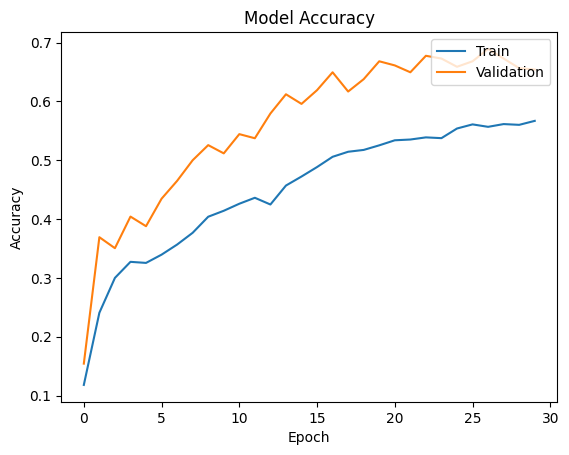

In [ ]:
# Let's Plot the Results to Evaluate
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Our test data is trending with our validation data, accuracy is slightly off

In [ ]:
# Now, let's evaluate the model on our testing data
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)


15/15 - 1s - loss: 1.0687 - accuracy: 0.6737 - 518ms/epoch - 35ms/step


Model 1 is classifying with an accuracy of ~67%

15/15 [==============================] - 0s 7ms/step


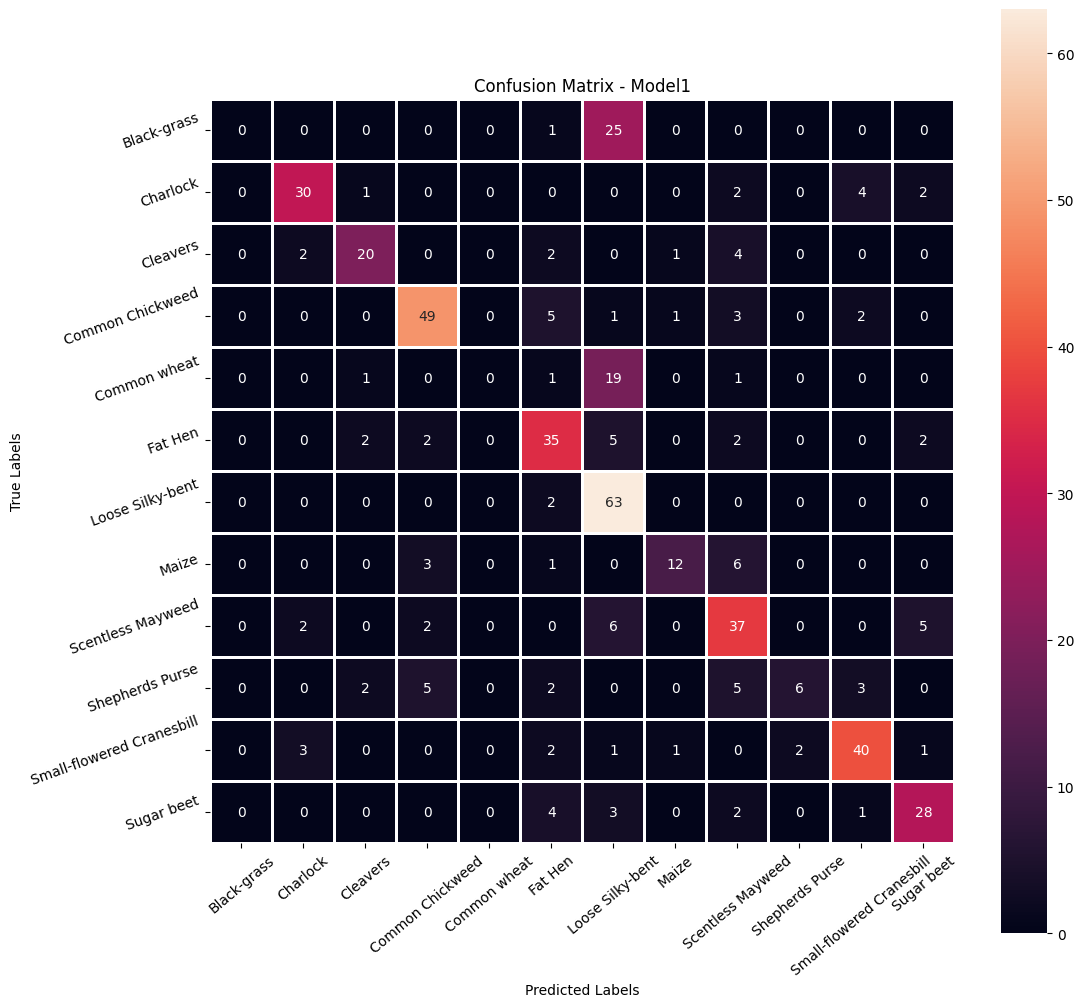

In [ ]:
# Predicting the output probabilities
y_pred = model1.predict(X_test_normalized)

# Obtain the categorical values from y_pred & y_test_encoded
y_pred_arg = np.argmax(y_pred, axis=1)
y_test_arg = np.argmax(y_test_encoded, axis=1)

# Plotting the Confusion Matrix using confusion_matrix() function
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)

# Plotting the confusion matrix using seaborn and matplotlib
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.75,
    fmt="d",
    square=True,
    ax=ax
)
# Add Labels to the Axis
ax.set_title('Confusion Matrix - Model1')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(list(encoder.classes_), rotation=40)
ax.yaxis.set_ticklabels(list(encoder.classes_), rotation=20)
plt.show()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.81      0.77      0.79        39
           2       0.77      0.69      0.73        29
           3       0.80      0.80      0.80        61
           4       0.00      0.00      0.00        22
           5       0.64      0.73      0.68        48
           6       0.51      0.97      0.67        65
           7       0.80      0.55      0.65        22
           8       0.60      0.71      0.65        52
           9       0.75      0.26      0.39        23
          10       0.80      0.80      0.80        50
          11       0.74      0.74      0.74        38

    accuracy                           0.67       475
   macro avg       0.60      0.58      0.57       475
weighted avg       0.63      0.67      0.64       475



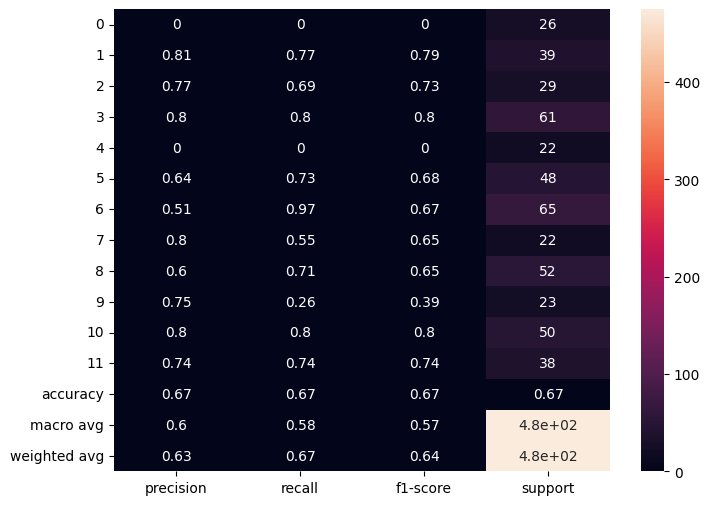

In [ ]:
# Printing Classification Report

# Generate Report
cr = metrics.classification_report(y_test_arg, y_pred_arg)
print(cr)

# Plot classification report

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(metrics.classification_report(y_test_arg, y_pred_arg, output_dict=True)).T, annot=True)
plt.show()

As shown above, our model needs some work. Let's move on to model improvement.

## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [ ]:
# Implementing ReduceLRomPlateau() Function
from tensorflow.keras.callbacks import ReduceLROnPlateau

# monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

In [ ]:
# Prep - clear backend
backend.clear_session()

# Prep - Fix seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Set Image Rotation Range to 20
train_datagen = ImageDataGenerator(rotation_range=20,fill_mode='nearest')

In [ ]:
# Initializing a sequential model
model2 = Sequential()

# Adding first convolutional layer with (64) filters and kernel size of 3x3
  # Padding 'same' provides the output size same as the input size
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Add max pooling to reduce the size of the output of the first convolutional layer
model2.add(MaxPooling2D((2, 2), padding='same'))
model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding='same'))
model2.add(BatchNormalization())

# Flatten output of the convolutional layer after max pooling
model2.add(Flatten())

# Add fully-connected dense layer with 16 neurons
model2.add(Dense(16, activation='relu'))

# Add Dropout with rate of 0.3
model2.add(Dropout(0.3))

# Add output layer with 12 neurons and activation function as softmax
model2.add(Dense(12, activation='softmax'))

# Adam Optimizer
optimizer = Adam()

# Compiling the model
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Generate Summary of Model2
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 16, 16, 32)        128       
 Normalization)                                                  
                                                        

In [ ]:
# Fit Model2 on Training Data
epochs = 30
batch_size = 64

history_2 = model2.fit(train_datagen.flow(X_train_normalized, y_train_encoded,batch_size=batch_size,shuffle=False),
                     epochs=epochs,
                     steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                     validation_data=(X_val_normalized, y_val_encoded),
                     verbose=1,
                     callbacks=[learning_rate_reduction]) # Learning Rate Reduction Callback

Epoch 1/30
60/60 [==============================] - 8s 129ms/step - loss: 0.6211 - accuracy: 0.7756 - val_loss: 0.6663 - val_accuracy: 0.8037 - lr: 6.2500e-05
Epoch 2/30
60/60 [==============================] - 6s 100ms/step - loss: 0.6081 - accuracy: 0.7671 - val_loss: 0.6800 - val_accuracy: 0.7991 - lr: 6.2500e-05
Epoch 3/30
60/60 [==============================] - 4s 71ms/step - loss: 0.6252 - accuracy: 0.7655 - val_loss: 0.6445 - val_accuracy: 0.8107 - lr: 6.2500e-05
Epoch 4/30
60/60 [==============================] - 6s 102ms/step - loss: 0.5991 - accuracy: 0.7777 - val_loss: 0.6613 - val_accuracy: 0.8084 - lr: 6.2500e-05
Epoch 5/30
60/60 [==============================] - 6s 95ms/step - loss: 0.6031 - accuracy: 0.7716 - val_loss: 0.6680 - val_accuracy: 0.8084 - lr: 6.2500e-05
Epoch 6/30
60/60 [==============================] - ETA: 0s - loss: 0.6108 - accuracy: 0.7803
Epoch 6: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
60/60 [==============================

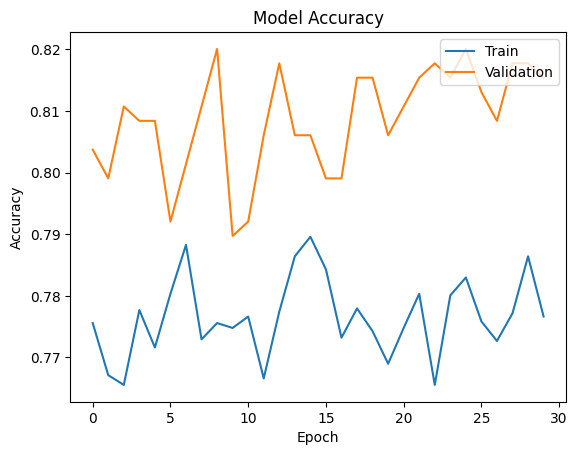

In [ ]:
# Let's Plot the Results to Evaluate
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Now, let's evaluate the model on our testing data
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.6622 - accuracy: 0.8084 - 331ms/epoch - 22ms/step


Model 2 has is predicting with an accuracy of ~80%

15/15 [==============================] - 0s 5ms/step


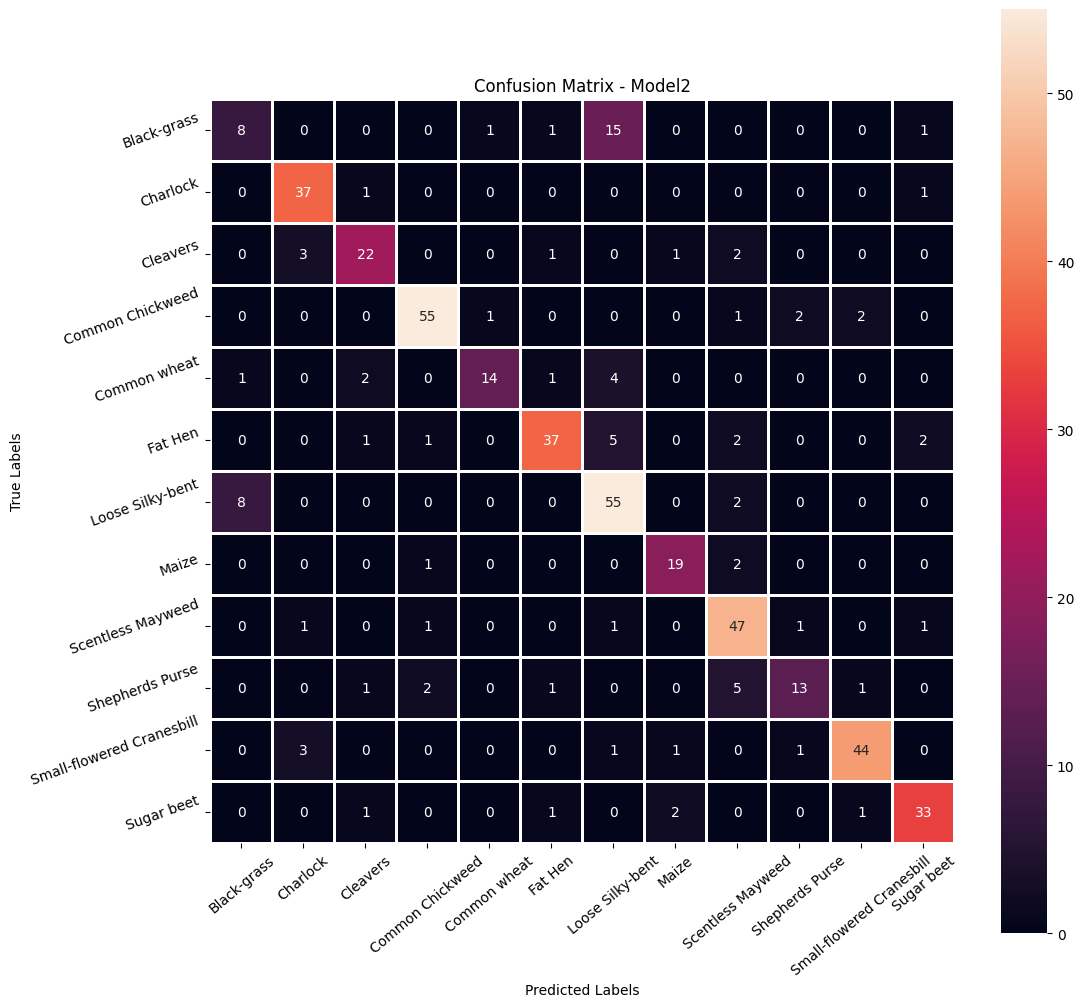

In [ ]:
# Predicting the output probabilities
y_pred = model2.predict(X_test_normalized)

# Obtain the categorical values from y_pred & y_test_encoded
y_pred_arg = np.argmax(y_pred, axis=1)
y_test_arg = np.argmax(y_test_encoded, axis=1)

# Plotting the Confusion Matrix using confusion_matrix() function
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)

# Plotting the confusion matrix using seaborn and matplotlib
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.75,
    fmt="d",
    square=True,
    ax=ax
)
# Add Labels to the Axis
ax.set_title('Confusion Matrix - Model2')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(list(encoder.classes_), rotation=40)
ax.yaxis.set_ticklabels(list(encoder.classes_), rotation=20)
plt.show()

              precision    recall  f1-score   support

           0       0.47      0.31      0.37        26
           1       0.84      0.95      0.89        39
           2       0.79      0.76      0.77        29
           3       0.92      0.90      0.91        61
           4       0.88      0.64      0.74        22
           5       0.88      0.77      0.82        48
           6       0.68      0.85      0.75        65
           7       0.83      0.86      0.84        22
           8       0.77      0.90      0.83        52
           9       0.76      0.57      0.65        23
          10       0.92      0.88      0.90        50
          11       0.87      0.87      0.87        38

    accuracy                           0.81       475
   macro avg       0.80      0.77      0.78       475
weighted avg       0.81      0.81      0.80       475



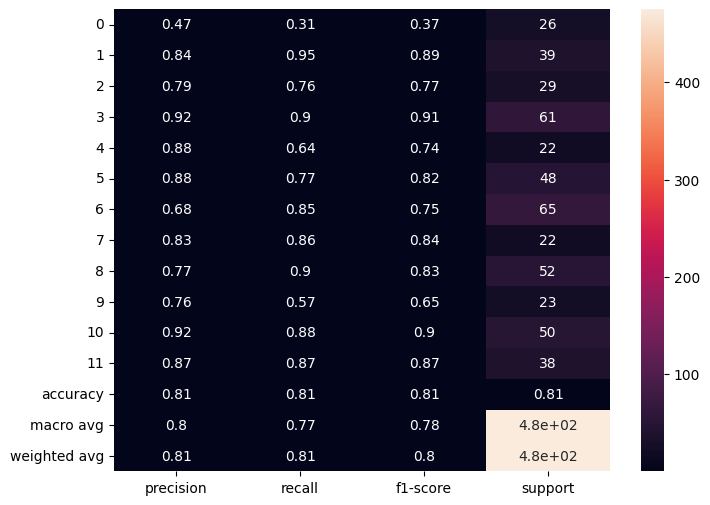

In [ ]:
# Printing Classification Report

# Generate Report
cr = metrics.classification_report(y_test_arg, y_pred_arg)
print(cr)

# Plot classification report

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(metrics.classification_report(y_test_arg, y_pred_arg, output_dict=True)).T, annot=True)
plt.show()

## Final Model

Comment on the final model you have selected and use the same in the below code to visualize the image.

Model 2 is scoring higher on each metric, therefore we will proceed with Model 2.

Model 2 precision = 0.81 (compared to Model 1's 0.63)
Model 2 recall = 0.81 (compared to Model 1's 0.67)
Model 2 f1-score = .80 (compared to Model 1's 0.64)

In [ ]:
# Assigning Final Model as Model 2
model_final = model2

## Visualizing Prediction of Final Model

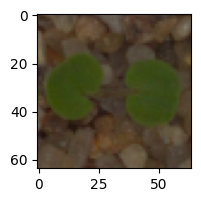

1/1 [==============================] - 0s 56ms/step
Predicted Label Index: 7
True Label (encoded): [0 0 0 0 0 0 0 0 0 0 1 0]


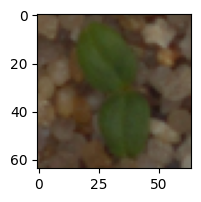

1/1 [==============================] - 0s 75ms/step
Predicted Label Index: 7
True Label (encoded): [0 0 1 0 0 0 0 0 0 0 0 0]


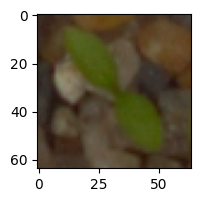

1/1 [==============================] - 0s 73ms/step
Predicted Label Index: 7
True Label (encoded): [0 0 0 1 0 0 0 0 0 0 0 0]


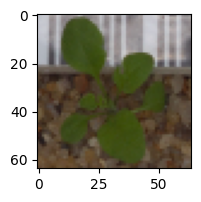

1/1 [==============================] - 0s 32ms/step
Predicted Label Index: 7
True Label (encoded): [0 0 0 0 0 0 0 0 0 1 0 0]


In [ ]:
# Visualizing the predicted and correct label of images from test data
def visualize_predictions(model, image, true_label_encoded):
    plt.figure(figsize=(2, 2))
    plt.imshow(image)
    plt.show()

    # Predict test data using final model - Model 2
    prediction = model.predict(image.reshape(1, 64, 64, 3))
    predicted_label_index = np.argmax(prediction, axis=-1)[0]

    print('Predicted Label Index:', predicted_label_index)
    print('True Label (encoded):', true_label_encoded)

# Visualize predictions for random images
visualize_predictions(model_final, X_test[2], y_test_encoded[2])
visualize_predictions(model_final, X_test[33], y_test_encoded[33])
visualize_predictions(model_final, X_test[59], y_test_encoded[59])
visualize_predictions(model_final, X_test[36], y_test_encoded[36])

## Actionable Insights and Business Recommendations

* As we have seen, the CNN model - 2 was able to predict the test image correctly with a test accuracy of 80.84%.

* There might still be scope for improvement in the accuracy of the CNN model chosen here. We could try adding a more dense layer to the models to see if we could get better accuracy than our current Model 2.

* Once we confirm that 80% passes the desired performance from the classifier model, the company can use it to classify different seedlings. The speed in which this model will work will be a great improvement to their current manual processes. Given time, it is possible to train this classifier model to have a higher accuracy score.

_____

In [ ]:
# Exporting notebook as HTML File
from nbconvert import HTMLExporter
import nbformat

# Read Notebook File
with open('/content/drive/MyDrive/DataScience/Project_8_CDNPlantSeedlingRecognition/High_Code_Plant_Seedling_Classification_Larson2023.ipynb', 'r') as f:
    notebook = nbformat.read(f, as_version=4)

# Initiate HTML Exporter
html_exporter = HTMLExporter()

# Convert Notebook to html file format
html_output, _ = html_exporter.from_notebook_node(notebook)

# Saving HTML so I can download
with open('/content/High_Code_Plant_Seedling_Classification_Larson2023.html', 'w') as x:
    x.write(html_output)